In [1]:
import logging
import pandas as pd
import argparse
import os
import glob
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(16,9)})

In [3]:
def parse_blast_output(filepath, extra_cols=None, extra_col_dtypes=None):
    std_blast_headers = [
        "query",
        "subj",
        "p_id",
        "aln_len",
        "mismatches",
        "gap_opens",
        "q_start",
        "q_end",
        "s_start",
        "s_end",
        "e_value",
        "bit_score",
        "qlen",
        "slen",
        "qcovs",
        "ppos"
    ]
    blast_dtypes = {
        "query": str,
        "subj": str,
        "aln_len": np.float16,
        "p_id": np.float16,
        "e_value": np.float64,
        "bit_score": np.float16,
    }
    if extra_cols is not None:
        std_blast_headers.extend(extra_cols)

    if extra_col_dtypes is not None:
        blast_dtypes.update(extra_col_dtypes)

    genome_name = os.path.basename(filepath).split(".")[0]

    return pd.read_table(
        filepath,
        header=None,
        names=std_blast_headers,
        dtype=blast_dtypes,
        usecols=blast_dtypes.keys(),
    ).assign(genome_id=genome_name)


def aggregate_blast_outputs(blastdir, ext, mapfile, output):
    blast_df = pd.concat(
        (
            parse_blast_output(blastfile)
            for blastfile in glob.iglob(os.path.join(blastdir, f"*{ext}"))
        )
    )
    map_df = pd.read_table(mapfile, header=None, names=["genome_id", "category"])

    summary_map_df = (
        map_df.value_counts("category")
        .reset_index()
        .rename(columns={"index": "category", "category": "total_genomes"})
    )

    genome_blast_df = pd.merge(
        blast_df, map_df, how="left", on="genome_id"
    ).reset_index(drop=True)

    summary_blast_df = [
        summarize_results(df, min_perc_id=70).assign(category=category_name)
        for category_name, df in genome_blast_df.groupby("category")
    ]

    pd.merge(summary_blast_df, summary_map_df, on="category", how="left").to_csv(output)

    return


In [4]:
def summarize_results(df, min_bit_score=None, evalue_cutoff=None, min_perc_id=None):
    if min_bit_score is None:
        min_bit_score = 0

    if evalue_cutoff is None:
        evalue_cutoff = 1

    if min_perc_id is None:
        min_perc_id = 70

    return (
        df.query(
            f"(bit_score >= {min_bit_score}) and (e_value <= {evalue_cutoff}) and (p_id >= {min_perc_id})"
        )
        .groupby("subj")
        .agg(presence = ("query", pd.Series.nunique))
    ).reset_index()

In [5]:
workdir = "/mnt/efs/scratch/sunit/Kazuki/Blast/all_firmicutes_db/firmicutes_genera.gte10"
blastdir = os.path.join(workdir, "gene_results", "blastx")
hCom_blastdir = os.path.join(workdir, "hCom_results", "blastx")
output = os.path.join(workdir,"agg_occurrance_by_genera.csv")
mapfile = os.path.join(workdir,"../firmicutes_genome_genera_map.tsv")

ext=".tsv.gz"

In [6]:
blast_df = pd.concat(
        (
            parse_blast_output(blastfile)
            for blastfile in glob.iglob(os.path.join(blastdir, f"*{ext}"))
        )
    ).reset_index(drop=True)
blast_df["source"] = "UHGG"
blast_df

,query,subj,p_id,aln_len,e_value,bit_score,genome_id,source
0,MGYG000092180_1:69390-71118,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,26.375000,201.0,1.370000e-05,44.312500,MGYG000092180,UHGG
1,MGYG000092180_1:69390-71118,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,23.375000,261.0,3.000000e-03,37.000000,MGYG000092180,UHGG
2,MGYG000092180_1:77582-78485,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,27.078125,229.0,4.730000e-12,62.812500,MGYG000092180,UHGG
3,MGYG000092180_1:77582-78485,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,21.796875,211.0,3.000000e-03,35.406250,MGYG000092180,UHGG
4,MGYG000092180_1:88995-89673,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,27.234375,224.0,6.900000e-20,84.312500,MGYG000092180,UHGG
...,...,...,...,...,...,...,...,...
458952,MGYG000153712_47:3871-4045,Clostridium-nexile-DSM-1787-MAF-2_Node_0_676,46.156250,26.0,5.100000e+00,21.593750,MGYG000153712,UHGG
458953,MGYG000153712_50:10223-11039,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,23.546875,242.0,4.330000e-08,50.406250,MGYG000153712,UHGG
458954,MGYG000153712_50:10223-11039,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,22.812500,206.0,3.100000e+00,25.796875,MGYG000153712,UHGG
458955,MGYG000153712_55:959-1643,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,25.781250,159.0,3.090000e-11,58.906250,MGYG000153712,UHGG


In [11]:
hCom_blast_df = pd.concat(
        (
            parse_blast_output(blastfile)
            for blastfile in glob.iglob(os.path.join(hCom_blastdir, f"*{ext}"))
        )
    ).reset_index(drop=True)
hCom_blast_df["genome_id"] = hCom_blast_df["genome_id"].apply(lambda x : x.replace("_protein",""))
hCom_blast_df["source"] = "hCom" 
hCom_blast_df

,query,subj,p_id,aln_len,e_value,bit_score,genome_id,source
0,Clostridium-bolteae-ATCC-BAA-613-MAF-2_Node_0_1,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,33.343750,39.0,7.700000e+00,25.406250,Clostridium-bolteae-ATCC-BAA-613-MAF-2,hCom
1,Clostridium-bolteae-ATCC-BAA-613-MAF-2_Node_0_22,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,31.031250,58.0,3.800000e+00,24.593750,Clostridium-bolteae-ATCC-BAA-613-MAF-2,hCom
2,Clostridium-bolteae-ATCC-BAA-613-MAF-2_Node_0_29,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,33.812500,71.0,4.500000e+00,25.406250,Clostridium-bolteae-ATCC-BAA-613-MAF-2,hCom
3,Clostridium-bolteae-ATCC-BAA-613-MAF-2_Node_0_44,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,26.359375,239.0,5.230000e-17,79.000000,Clostridium-bolteae-ATCC-BAA-613-MAF-2,hCom
4,Clostridium-bolteae-ATCC-BAA-613-MAF-2_Node_0_44,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,26.437500,208.0,8.750000e-15,72.000000,Clostridium-bolteae-ATCC-BAA-613-MAF-2,hCom
...,...,...,...,...,...,...,...,...
4378,Eubacterium-rectale-ATCC-33656_Node_0_3173,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,24.625000,203.0,3.850000e-06,44.687500,Eubacterium-rectale-ATCC-33656,hCom
4379,Eubacterium-rectale-ATCC-33656_Node_0_3218,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,40.750000,27.0,4.500000e+00,24.593750,Eubacterium-rectale-ATCC-33656,hCom
4380,Eubacterium-rectale-ATCC-33656_Node_0_3223,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,43.468750,23.0,9.400000e+00,24.296875,Eubacterium-rectale-ATCC-33656,hCom
4381,Eubacterium-rectale-ATCC-33656_Node_0_3249,Clostridium-nexile-DSM-1787-MAF-2_Node_0_676,37.500000,24.0,8.700000e+00,25.406250,Eubacterium-rectale-ATCC-33656,hCom


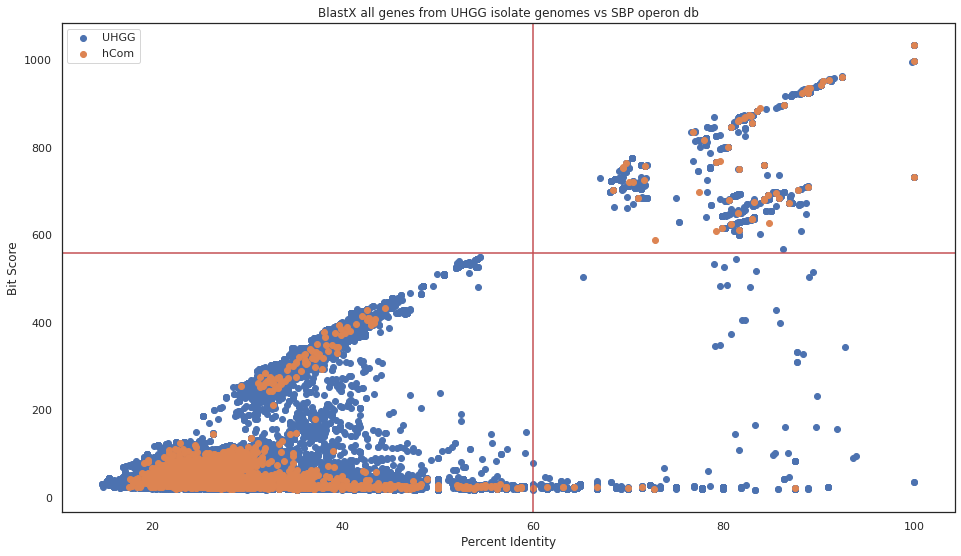

In [32]:
bit_score_threshold = 560
perc_id_threshold = 60
for name, df in pd.concat([blast_df, hCom_blast_df]).groupby("source"):
    plt.scatter(df["p_id"],df["bit_score"], label = name)
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.axhline(y=bit_score_threshold, color='r', linestyle='-')
plt.axvline(x=perc_id_threshold, color='r', linestyle='-')
plt.xlabel("Percent Identity")
plt.ylabel("Bit Score")
plt.title("BlastX all genes from UHGG isolate genomes vs SBP operon db")
plt.show()
plt.close()

In [33]:
map_df = pd.read_table(mapfile, header=None, names=["genome_id", "category"])
map_df

,genome_id,category
0,MGYG000000002,Blautia_A
1,MGYG000000004,Anaerotruncus
2,MGYG000000006,Staphylococcus
3,MGYG000000007,Lactobacillus
4,MGYG000000008,Lactobacillus
...,...,...
2169,MGYG000289060,Clostridioides
2170,MGYG000289160,Clostridioides
2171,MGYG000289244,Clostridioides
2172,MGYG000289265,Blautia_A


In [156]:
summary_map_df = (
    map_df.value_counts("category")
    .reset_index()
    .rename(columns={0: "total_genomes"})
)
summary_map_df.to_csv(os.path.join(workdir, "genomes_per_genus.csv"), index=False)
summary_map_df.head(10)

,category,total_genomes
0,Clostridioides,260
1,Enterococcus_B,237
2,Blautia_A,162
3,Streptococcus,88
4,Mediterraneibacter,65
5,Lacticaseibacillus,58
6,Agathobacter,57
7,Enterococcus,57
8,Faecalibacillus,50
9,Enterocloster,47


In [35]:
genome_blast_df = pd.merge(
    blast_df, map_df, how="left", on="genome_id"
).reset_index(drop=True)
genome_blast_df

,query,subj,p_id,aln_len,e_value,bit_score,genome_id,source,category
0,MGYG000092180_1:69390-71118,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,26.375000,201.0,1.370000e-05,44.312500,MGYG000092180,UHGG,Blautia_A
1,MGYG000092180_1:69390-71118,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,23.375000,261.0,3.000000e-03,37.000000,MGYG000092180,UHGG,Blautia_A
2,MGYG000092180_1:77582-78485,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,27.078125,229.0,4.730000e-12,62.812500,MGYG000092180,UHGG,Blautia_A
3,MGYG000092180_1:77582-78485,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,21.796875,211.0,3.000000e-03,35.406250,MGYG000092180,UHGG,Blautia_A
4,MGYG000092180_1:88995-89673,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,27.234375,224.0,6.900000e-20,84.312500,MGYG000092180,UHGG,Blautia_A
...,...,...,...,...,...,...,...,...,...
458952,MGYG000153712_47:3871-4045,Clostridium-nexile-DSM-1787-MAF-2_Node_0_676,46.156250,26.0,5.100000e+00,21.593750,MGYG000153712,UHGG,Erysipelatoclostridium
458953,MGYG000153712_50:10223-11039,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,23.546875,242.0,4.330000e-08,50.406250,MGYG000153712,UHGG,Erysipelatoclostridium
458954,MGYG000153712_50:10223-11039,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,22.812500,206.0,3.100000e+00,25.796875,MGYG000153712,UHGG,Erysipelatoclostridium
458955,MGYG000153712_55:959-1643,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,25.781250,159.0,3.090000e-11,58.906250,MGYG000153712,UHGG,Erysipelatoclostridium


In [36]:
summary_blast_df = pd.concat(
        (summarize_results(df, min_perc_id=perc_id_threshold, min_bit_score=bit_score_threshold).assign(genome_id=name)
        for name, df in genome_blast_df.groupby("genome_id"))
    ).pivot(index="genome_id", columns="subj", values="presence") 
    

summary_blast_df

subj,Clostridium-nexile-DSM-1787-MAF-2_Node_0_674,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,Clostridium-nexile-DSM-1787-MAF-2_Node_0_676
genome_id,,,
MGYG000000018,1,1,1
MGYG000000032,1,1,1
MGYG000000038,1,1,1
MGYG000000077,1,1,1
MGYG000000090,1,1,1
...,...,...,...
MGYG000284369,1,1,1
MGYG000284571,1,1,1
MGYG000288480,1,1,1


In [37]:
summary_blast_df.sum(axis=1).reset_index().rename(columns={0:"total"}).sort_values(["total"], ascending=False).query("total >= 3")

,genome_id,total
0,MGYG000000018,3.0
250,MGYG000176411,3.0
260,MGYG000183318,3.0
259,MGYG000182612,3.0
258,MGYG000182379,3.0
...,...,...
133,MGYG000076575,3.0
134,MGYG000077212,3.0
135,MGYG000077491,3.0
124,MGYG000068879,3.0


In [31]:
complete_operons_df = (
    pd.merge(summary_blast_df, map_df, on="genome_id", how="left")
        .set_index(["category","genome_id"])
        .sum(axis=1)
        .reset_index()
        .rename(columns={0:"total"})
        .query("total >= 3")
        .sort_values(["genome_id"])
)
complete_operons_df

,category,genome_id,total
0,Coprococcus,MGYG000000018,3.0
1,Hungatella,MGYG000000032,3.0
2,Dorea_A,MGYG000000038,3.0
3,Anaerobutyricum,MGYG000000077,3.0
4,Lawsonibacter,MGYG000000090,3.0
...,...,...,...
381,Agathobacter,MGYG000284369,3.0
382,Dorea_A,MGYG000284571,3.0
383,Hungatella,MGYG000288480,3.0
384,Blautia,MGYG000288705,3.0


In [72]:
genus_summary_df = complete_operons_df.value_counts("category").reset_index().rename(columns={0:"genomes_w_complete_operon"})
genus_summary_df_out = pd.merge(genus_summary_df, summary_map_df, how="left", on="category")
genus_summary_df_out.to_csv(output, index=False)
genus_summary_df_out

,category,genomes_w_complete_operon,total_genomes
0,Agathobacter,54,57
1,Coprococcus,33,39
2,Dorea,33,35
3,Enterocloster,29,47
4,Fusicatenibacter,27,29
5,Dorea_A,23,24
6,Blautia,21,21
7,Mediterraneibacter,21,65
8,Eisenbergiella,21,23
9,Eubacterium_G,20,22


In [23]:
# def summarize_results2(df, min_bit_score=None, evalue_cutoff=None, min_perc_id=None):
#     if min_bit_score is None:
#         min_bit_score = 0

#     if evalue_cutoff is None:
#         evalue_cutoff = 1

#     if min_perc_id is None:
#         min_perc_id = 70

#     return (
#         df.query(
#             f"(bit_score >= {min_bit_score}) and (e_value <= {evalue_cutoff}) and (p_id >= {min_perc_id})"
#         )
#         .groupby("subj")
#         .agg(presence = ("query", pd.Series.nunique))
#     ).reset_index()

summary_hCom_blast_df = pd.concat(
        (summarize_results(df, min_perc_id=perc_id_threshold, min_bit_score=bit_score_threshold).assign(genome_id=name)
        for name, df in hCom_blast_df.groupby("genome_id"))
    ).pivot(index="genome_id", columns="subj", values="presence") 
    

summary_hCom_blast_df

subj,Clostridium-nexile-DSM-1787-MAF-2_Node_0_674,Clostridium-nexile-DSM-1787-MAF-2_Node_0_675,Clostridium-nexile-DSM-1787-MAF-2_Node_0_676
genome_id,,,
Anaerobutyricum-hallii-DSM-3353-MAF-2,1,1,1
Blautia-hansenii-DSM-20583-MAF-2,1,1,1
Bryantella-formatexigens-DSM-14469-MAF-2,1,1,1
Clostridiales-bacterium-VE202-27-MAF-1,1,1,1
Clostridium-bolteae-ATCC-BAA-613-MAF-2,1,1,1
Clostridium-hathewayi-DSM-13479-MAF-NJ35,1,1,1
Clostridium-nexile-DSM-1787-MAF-2,1,1,1
Clostridium-sp-L2-50-MAF-1,1,1,1
Clostridium-sp-M62-1-MAF-2,1,1,1
